# Data Stream Processing - Project 3 : EXstream

In [1]:
# Import librairies.
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby


## The data

In [2]:
# Get files
DATAPATH =  "../data/custom_no_streaming_8/folder_1"
files = glob.glob(rf"{DATAPATH}/*")
files

['../data/custom_no_streaming_8/folder_1\\1_1.csv',
 '../data/custom_no_streaming_8/folder_1\\1_2.csv',
 '../data/custom_no_streaming_8/folder_1\\2_1.csv',
 '../data/custom_no_streaming_8/folder_1\\2_2.csv',
 '../data/custom_no_streaming_8/folder_1\\3_1.csv',
 '../data/custom_no_streaming_8/folder_1\\3_2.csv',
 '../data/custom_no_streaming_8/folder_1\\labels.csv']

In [3]:
# Read anomaly files and concatenate dataframes
dfs = []
for file in files[:-1]:
    df = pd.read_csv(file)
    # Extract the filename without the parent folder path and extension
    filename = file.split('\\')[-1].split('.')[0]
    # Add a new column "anomaly_type" with the extracted filename
    df.insert(1, column="trace_id", value=filename)
    df.rename({"Unnamed: 0": "time"}, axis=1, inplace=True)
    dfs.append(df)

# Concatenate all dataframes except labels.csv
anomaly_df = pd.concat(dfs)

# Create a separate dataframe for labels.csv
labels_df = pd.read_csv(files[-1], index_col=0)

# Print the resulting dataframes
print("Concatenated DataFrame (except labels.csv):")
print(anomaly_df.shape)

print("\nLabels DataFrame:")
print(labels_df.shape)

Concatenated DataFrame (except labels.csv):
(272935, 10)

Labels DataFrame:
(29, 7)


In [4]:
# Rename values in the "anomaly_type" column based on the specified mapping
mapping = {
    "1_1": "bursty_input",
    "1_2": "bursty_input",
    "2_1": "stalled_input",
    "2_2": "stalled_input",
    "3_1": "cpu_contention",
    "3_2": "cpu_contention"
}
anomaly_df.insert(2, column="anomaly_type", value=anomaly_df['trace_id'].replace(mapping))


In [5]:
# Missing values.
anomaly_df.isna().sum()

time                                                   0
trace_id                                               0
anomaly_type                                           0
driver_BlockManager_memory_memUsed_MB_value            0
driver_jvm_heap_used_value                             0
avg_jvm_heap_used_value                                0
avg_executor_filesystem_hdfs_write_ops_value_1_diff    0
avg_executor_cpuTime_count_1_diff                      0
avg_executor_runTime_count_1_diff                      0
avg_executor_shuffleRecordsRead_count_1_diff           0
avg_executor_shuffleRecordsWritten_count_1_diff        0
dtype: int64

In [6]:
bursty_input1_df = anomaly_df[anomaly_df["trace_id"] == "1_1"]

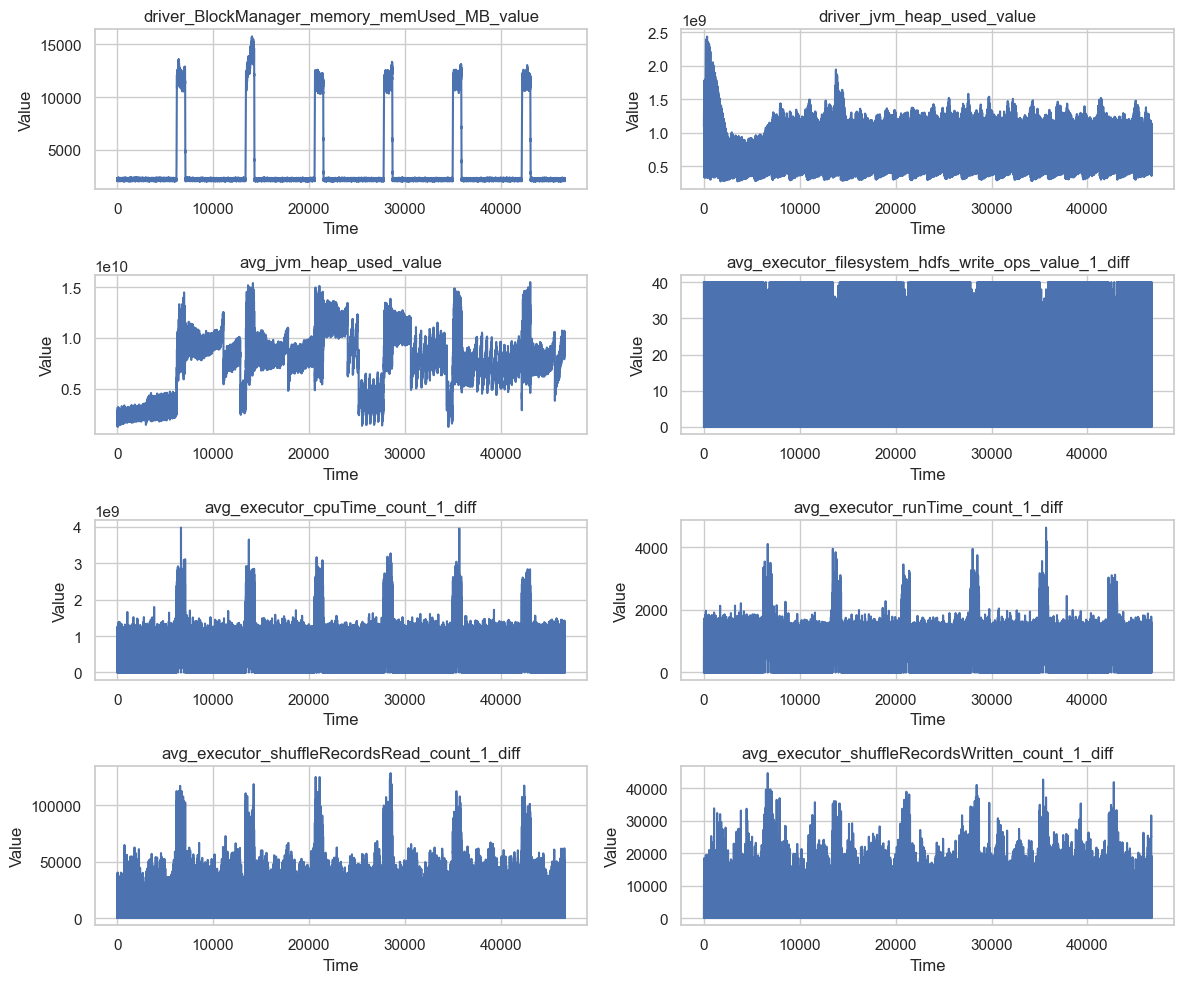

In [7]:
# Extract columns excluding the first three
columns_to_plot = bursty_input1_df.columns[3:]

# Set up the subplot grid
num_rows = 4
num_cols = 2

# Create a new figure with seaborn style
plt.figure(figsize=(12, 10))
sns.set(style="whitegrid")

# Plot each column in the grid
for i, column in enumerate(columns_to_plot, 1):  # Start index at 1 for better subplot titles
    plt.subplot(num_rows, num_cols, i)
    sns.lineplot(x='time', y=column, data=bursty_input1_df)
    plt.title(column)
    plt.xlabel('Time')
    plt.ylabel('Value')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Sufficient features space

Input
- Abnormal interval: $I_A$.
- Reference interval $I_R$.

Ouput
- [ ] List of all the features occuring either during $I_A$ or $I_R$. 
  - [ ] Filter the data according to the time two intervals.
  - [ ] Remove features that do not vary during this intervals / Select all the features varying during this time interval.

In [8]:
#---CODE HERE----


# Function to annotate periods
def annotate_period(row, labels_df):
    for i, label_row in labels_df.iterrows():
        if row['trace_id'] == label_row['trace_id']:
            if label_row['ref_start'] <= row['time'] < label_row['ref_end']:
                return 'I_R'
            if label_row['ano_start'] <= row['time'] < label_row['ano_end']:
                return 'I_A'
    return "not_a_period"

# Apply the function to annotate periods
bursty_input1_df['period_type'] = bursty_input1_df.apply(lambda row: annotate_period(row, labels_df), axis=1)


bursty_input1_df_filter = bursty_input1_df[bursty_input1_df["period_type"] != "not_a_period"]
#bursty_input1_df[bursty_input1_df["period_type"] == "I_R"].to_csv("bursty_input1_ref.csv", sep = ";")

continuous_features = [
    'driver_BlockManager_memory_memUsed_MB_value',
    'driver_jvm_heap_used_value',
    'avg_jvm_heap_used_value',
    'avg_executor_filesystem_hdfs_write_ops_value_1_diff',
    'avg_executor_cpuTime_count_1_diff',
    'avg_executor_runTime_count_1_diff',
    'avg_executor_shuffleRecordsRead_count_1_diff',
    'avg_executor_shuffleRecordsWritten_count_1_diff'
]

# Calculate variance for the specified continuous features
continuous_variances = bursty_input1_df_filter[continuous_features].var()

# Select continuous features with variance above a threshold (e.g., 0)
selected_continuous_features = continuous_variances[continuous_variances > 0].index.tolist()

# Since we are only dealing with continuous variables here,
bursty_input1_df_final = bursty_input1_df_filter[selected_continuous_features + ["time"]]



C:\Users\choho\AppData\Local\Temp\ipykernel_29452\4275239986.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bursty_input1_df['period_type'] = bursty_input1_df.apply(lambda row: annotate_period(row, labels_df), axis=1)


def annotate_anomaly(row, labels_df):
    for i, label_row in labels_df.iterrows():
        if row['trace_id'] == label_row['trace_id']:
            if label_row['ref_start'] <= row['time'] < label_row['ref_end']:
                return row['ano_id']
            if label_row['ano_start'] <= row['time'] < label_row['ano_end']:
                return row['ano_id']
    return "not_an_anomaly_ref_or_ano"
#bursty_input1_df['ano_id'] = bursty_input1_df.apply(lambda row: annotate_anomaly(row, labels_df), axis=1)


## Single feature reward (section 4)

Workflow:
* [x] Class Entropy
* [x] Segmentation Entropy
* [x] Penalization (for mixed segments)
* [x] Normalization by feature size

### Class entropy

**Input**
* $TS_A$, $TS_R$ two time series from the abnormal and the reference intervals respectively.

**Compute**

* $|TS_A|$, $|TS_A|$: number of points in the two series.
* The weight of each series (empirical probability that one point belong to that class).
$$
    p_A = \frac{|TS_A|}{|TS_A| + |TS_R|}, \quad p_R = \frac{|TS_R|}{|TS_A| + |TS_R|}
$$
* The class entropy of the feature $f$:
$$
    H_{Class}(f) = p_A \cdot \log\left(\frac{1}{p_A}\right) + p_R \cdot \log\left(\frac{1}{p_R}\right)
$$

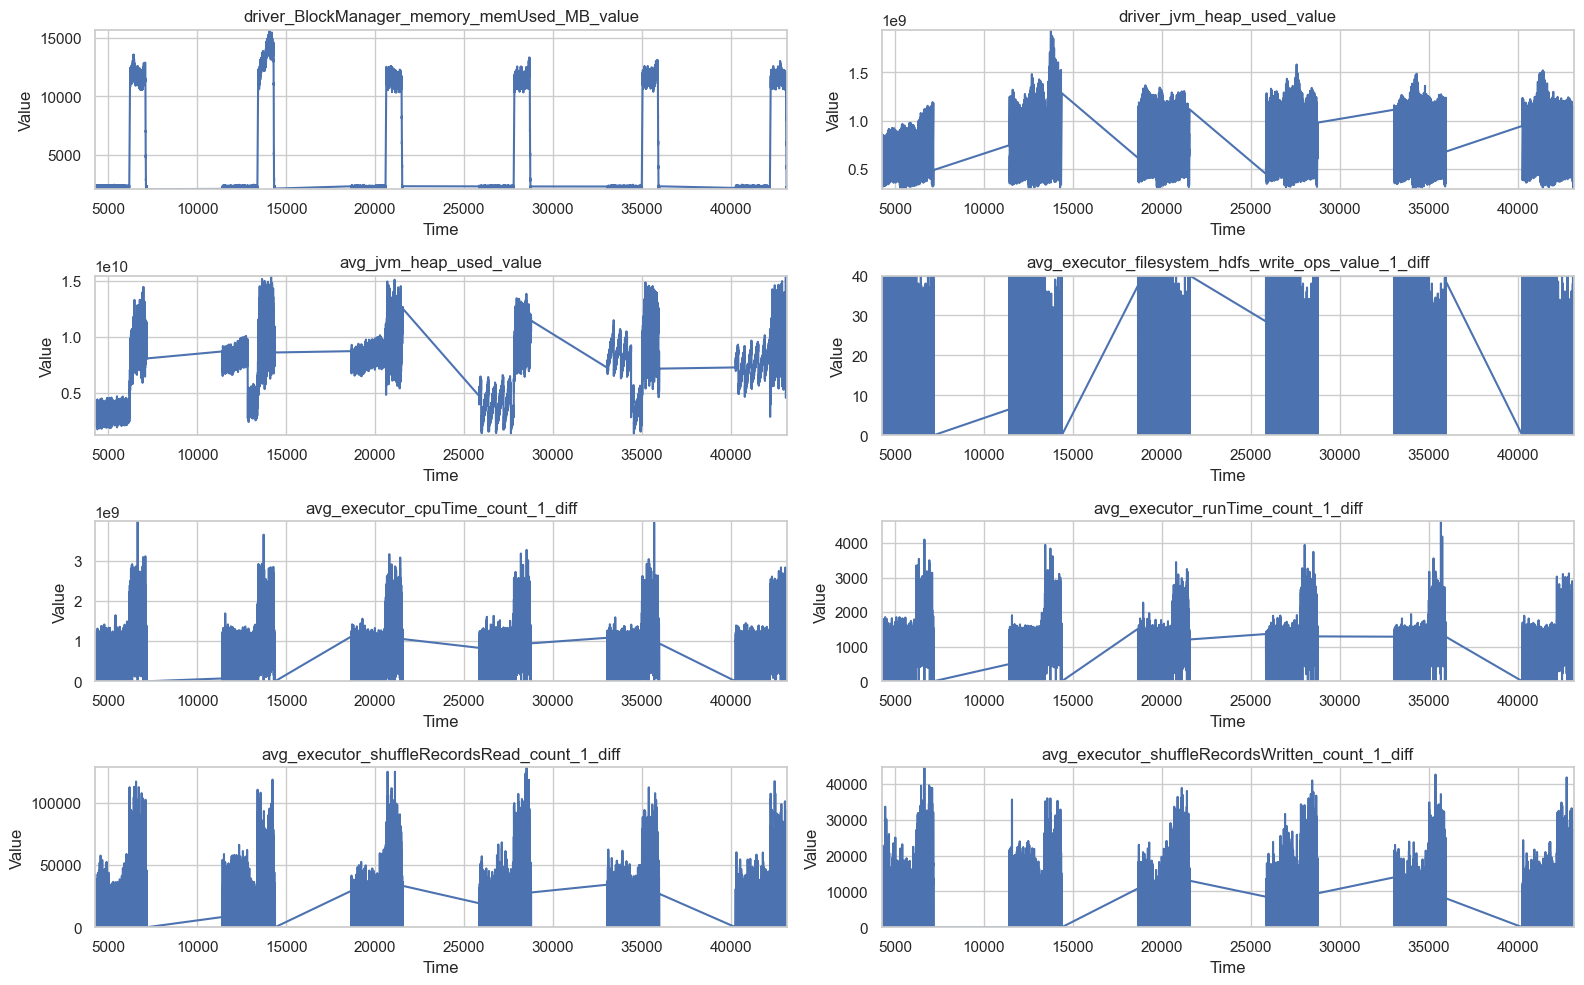

In [9]:
#---CODE HERE----

# Assuming bursty_input1_df_final is your DataFrame and selected_continuous_features is your list of features.

# Set up the subplot grid
num_rows = len(continuous_features) // 2 + 1
num_cols = 2

# Create a new figure with seaborn style
plt.figure(figsize=(16, 12))  # Adjusted figure size for better visibility
sns.set(style="whitegrid")

# Plot each column in the grid
for i, column in enumerate(selected_continuous_features, 1):  # Start index at 1 for better subplot titles
    ax = plt.subplot(num_rows, num_cols, i)
    sns.lineplot(x='time', y=column, data=bursty_input1_df_final, ax=ax)
    plt.title(column)
    plt.xlabel('Time')
    plt.ylabel('Value')
    
    # Set the limits based on each column's data for better scale representation
    plt.ylim(bursty_input1_df_final[column].min(), bursty_input1_df_final[column].max())
    plt.xlim(bursty_input1_df_final['time'].min(), bursty_input1_df_final['time'].max())

plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()  # Display the plot


In [10]:
TSR = bursty_input1_df_filter[bursty_input1_df_filter["period_type"] == "I_R"]
TSA = bursty_input1_df_filter[bursty_input1_df_filter["period_type"] == "I_A"]

def class_entropy(TSA, TSR):
    p_A = len(TSA) / (len(TSA) + len(TSR))
    p_R = len(TSR) / (len(TSA) + len(TSR))

    H_Class_f = p_A * np.log(1/p_A) + p_R * np.log(1/p_R)
    return H_Class_f

class_entropy(TSA, TSR)

0.6365141682948128

### Segmentation entropy (???)

**Input**
* Time series $TS$ of a feature $f$: $(X_t)_{t=1,\dots,T}$. 
* Anomaly time annotations: $A_S = (a_s)_{s=1,\dots, S}  \subset \{1, \dots, T\}$  

Example: In the sequence, AANNNNANNN. The anomaly time anotations would be (1,2,7). We are given only the different time intervals from which we have to derive the different anomaly time anotation and then the segment (this is just an heuristic, not necessarily the way it would be implemented).

**Compute**
* The segments. A segment is a (contiguous) sequence of point with the same label (anomaly or not anomaly)
* The segmentation entropy of the feature $f$:
$$
    H_{Segmentation}(f) = \sum_{i=1}^{n} p_i \cdot \log\left(\frac{1}{p_i}\right)
$$

In [11]:
#---CODE HERE----
def generate_TS(bursty_input1_df_filter, variable):
    # new DataFrame to store the unique values and their associated period_type
    unique_values_df = bursty_input1_df_filter[[variable, 'period_type']].drop_duplicates()

    # Grouped by variable and determine the period type for each value
    grouped = unique_values_df.groupby(variable)['period_type']

    # Determine the period type for each unique value
    TS = grouped.apply(lambda x: 'I_M' if set(x) == {'I_R', 'I_A'} else x.iloc[0])
    #TS.to_csv("TS.csv", sep = ";")
    return TS

TS = generate_TS(bursty_input1_df_filter, "driver_BlockManager_memory_memUsed_MB_value")


def segmentation_entropy(TS):
    # Group the series by consecutive identical values and get segment lengths
    segments = [(k, sum(1 for _ in g)) for k, g in groupby(TS)]

    # segments by length (even lengths only)
    filtered_segments = [seg for seg in segments if seg[1] % 2 == 0]
    
    # Calculate segment probabilities
    total_length = sum(length for _, length in filtered_segments)
    probabilities = [length / total_length for _, length in filtered_segments]
    
    # Calculate segmentation entropy
    H_Segmentation_f = -sum(p * np.log(p) for p in probabilities if p > 0)  # avoid log(0)
    
    return H_Segmentation_f

H_Segmentation = segmentation_entropy(TS)
print(f"The segmentation entropy of the feature is: {H_Segmentation}")
print(TS.unique())

The segmentation entropy of the feature is: 0.5176942062148837
['I_R' 'I_M' 'I_A']


groupby(TS): This groups the TS series by consecutive identical values. It returns keys (k) and groups (g). The key is the value around which the grouping is done (e.g., 'I_R', 'I_A', or 'I_M'), and the group is an iterator that you can loop over to get all items in the group.

### Penalization for mixed segments

$$
    H^+_{Segmentation}(f) = H_{Segmentation}(f) + \sum_{j=1}^{m} H_{Segmentation}(c_j^*)
$$

In [12]:
def regularized_segmentation_entropy(segments):
    """
    Calculate the penalty for mixed segments by assuming the worst-case ordering.
    
    input:
    segments (list of tuples): A list where each tuple represents a segment and its length.

    output:
    float: The penalty for mixed segments.
    """
    penalty = 0.0
    segments = [(k, sum(1 for _ in g)) for k, g in groupby(TS)]
    # Filter segments by length (even lengths only)
    #filtered_segments = [seg for seg in segments if seg[1] % 2 == 0]
    
    # Calculate segment probabilities
    # total_length = sum(length for _, length in filtered_segments)  #pas sûr
    
    # Loop through each segment
    for label, length in segments:
        # Check if the segment is mixed
        if label == 'I_M':
            # Assume a worst-case scenario where each point in the segment
            # alternates between classes, resulting in maximum entropy
            for i in range(length):
                p_i = 1 / length    # Probability of each point in the segment
                penalty += p_i * np.log(p_i)
    return -penalty  # The penalty is subtracted so we return a positive value



In [13]:
def segmentation_entropy_plus(TS):
    return segmentation_entropy(TS) + regularized_segmentation_entropy(TS)

print(f"The segmentation entropy with mixed segment penalty is: {segmentation_entropy_plus(TS)}")


The segmentation entropy with mixed segment penalty is: 35.20125538514406


### Normalization by feature size

In [14]:
def entropy_feature_distance(class_entropy_value, segmentation_entropy_plus_value):
    """
    Calculate the entropy-based feature distance.
    
    Args:
    H_Class_f (float): The class entropy of the feature.
    H_Segmentation_plus (float): The regularized segmentation entropy of the feature.

    Returns:
    float: The entropy-based feature distance.
    """
    
    return class_entropy_value / segmentation_entropy_plus_value if segmentation_entropy_plus_value != 0 else 0


Distance = entropy_feature_distance(class_entropy(TSA, TSR), segmentation_entropy_plus(TS))
print(f"Feature Distance: {Distance}")


Feature Distance: 0.01808214398408757


## Constructing explanations (section 5)

# Step 1
5.1 Step 1: reward leap filtering The single-feature distance function produces a ranking of
all features based on their individual rewards. Sharp changesin the reward between successive features in the ranking indicate a semantic change: Features that rank below a sharp drop in the reward are unlikely to contribute to an explanation. Therefore, features whose distance is low, relatively to
other features, can be safely discarded.

Features with more complex segmentation have lower rewards

Feature Distance for driver_BlockManager_memory_memUsed_MB_value: 0.01808214398408757


Feature Distance for driver_jvm_heap_used_value: 0.08324580813823633
Feature Distance for avg_jvm_heap_used_value: 0.11500312555739749
Feature Distance for avg_executor_filesystem_hdfs_write_ops_value_1_diff: 0.14484504107142399
Feature Distance for avg_executor_cpuTime_count_1_diff: 0.10889281514929382
Feature Distance for avg_executor_runTime_count_1_diff: 0.0020413132260350257
Feature Distance for avg_executor_shuffleRecordsRead_count_1_diff: 0.09163212355755058
Feature Distance for avg_executor_shuffleRecordsWritten_count_1_diff: 0.026210471059061415


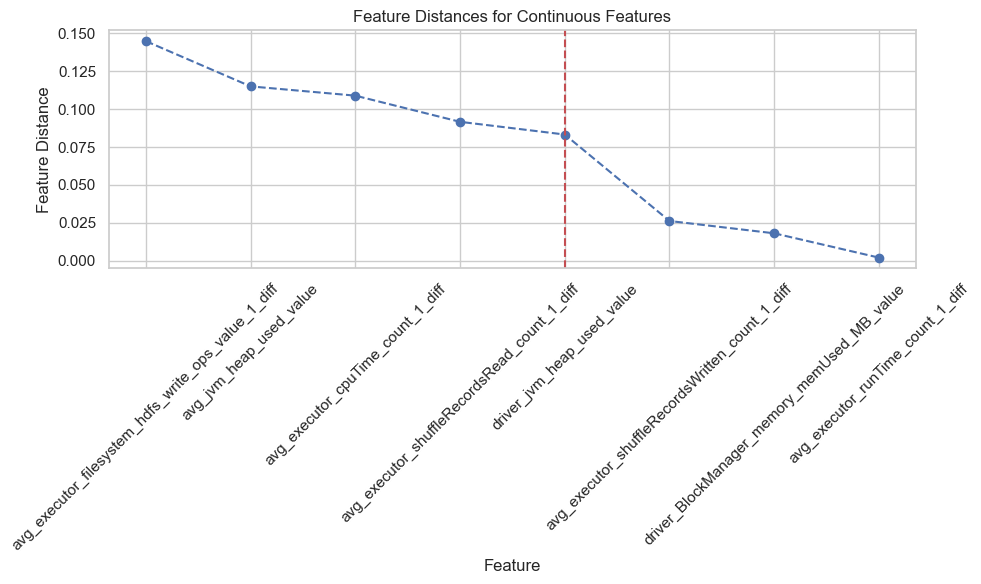

Significant features: ('avg_executor_filesystem_hdfs_write_ops_value_1_diff', 'avg_jvm_heap_used_value', 'avg_executor_cpuTime_count_1_diff', 'avg_executor_shuffleRecordsRead_count_1_diff', 'driver_jvm_heap_used_value')


In [15]:
feature_distances = {}

for variable in continuous_features :
    TS = generate_TS(bursty_input1_df_filter, variable)
    H_Segmentation = segmentation_entropy(TS)
    H_Segmentation_plus = segmentation_entropy_plus(TS)
    Distance = entropy_feature_distance(class_entropy(TSA, TSR), segmentation_entropy_plus(TS))
    feature_distances[variable] = Distance
    print(f"Feature Distance for {variable}: {Distance}")

sorted_features = sorted(feature_distances.items(), key=lambda x: x[1], reverse=True)

def plot_feature_distances_with_elbow(sorted_features):
    variables, distances = zip(*sorted_features)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(variables, distances, marker='o', linestyle='--', color='b')
    plt.xlabel('Feature')
    plt.ylabel('Feature Distance')
    plt.title('Feature Distances for Continuous Features')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Calculate differences between successive feature distances
    differences = [distances[i] - distances[i+1] for i in range(len(distances)-1)]

    # Threshold defined by the max dropout in distances
    threshold = max(differences)
    elbow_point = differences.index(threshold)

    # Add a red line to indicate the elbow point
    plt.axvline(x=variables[elbow_point], color='r', linestyle='--')

    # Show the plot
    plt.show()

    # Return significant features
    return variables[:elbow_point+1]

# Example usage
significant_features = plot_feature_distances_with_elbow(sorted_features)
print("Significant features:", significant_features)



# Step 2: false positive filtering

# Step 3: filtering by correlation clustering

# 5.4 Building final explanations
